# Hyperparameter Tuning for a Single Doc RAG

In [1]:
!pip install llama_index==0.9.3 pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.7/886.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


## Load document

In [2]:
import os, openai, logging, sys
import nest_asyncio

nest_asyncio.apply()

OPENAI_API_KEY = "sk-..."
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [9]:
!ls sample_data/data

DevOps_Self-Service_Pipeline_Architecture.pdf
DevOps_Self-Service_Pipeline_Security_Guardrails.pdf
DevOps_Self-Service_Terraform_Project_Structure.pdf


In [10]:
from llama_index import ServiceContext, SimpleDirectoryReader
from llama_index.llms import OpenAI
from llama_index.text_splitter import SentenceSplitter

documents = SimpleDirectoryReader("sample_data/data").load_data()
print(f"loaded documents with {len(documents)} documents")

# Use the new flattened interface for node parsing
node_parser = SentenceSplitter(chunk_size=256)
nodes = node_parser(documents)
print(f"loaded {len(nodes)} nodes")

loaded documents with 49 documents


[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loaded 105 nodes


## Generate evaluation question/answer pairs

In [11]:
from llama_index.evaluation import (
    DatasetGenerator,
    QueryResponseDataset,
)

eval_service_context = ServiceContext.from_defaults(llm=OpenAI(model="gpt-4-1106-preview"))

# load eval question/answer dataset from JSON file if exists
if os.path.exists("sample_data/data/eval_qr_dataset.json"):
    eval_dataset = QueryResponseDataset.from_json("data/eval_qr_dataset.json")
else:
    # construct dataset_generator
    dataset_generator = DatasetGenerator(
        nodes[:8],
        service_context=eval_service_context,
        show_progress=True,
        num_questions_per_chunk=2,
    )

    # generate queries and responses
    eval_dataset = dataset_generator.generate_dataset_from_nodes()

    # save the dataset into a file
    eval_dataset.save_json("sample_data/data/eval_qr_dataset.json")

100%|██████████| 2/2 [00:15<00:00,  7.94s/it]


In [13]:
import json

# Load dataset from JSON file
with open("sample_data/data/eval_qr_dataset.json", "r") as file:
    eval_dataset_content = json.load(file)

# Print the content in JSON format
json_str = json.dumps(eval_dataset_content, indent=2)  # indent for pretty printing
print(json_str)

{
  "queries": {
    "9452c4ad-171b-46a2-ab62-f92e1b4237ea": "Explain the concept of \"DevOps self-service\" as described in the document \"DevOps_Self-Service_Pipeline_Architecture.pdf\" and discuss how it aims to transform the mindset of developers in terms of access, control, and ownership of pipelines.",
    "60ebac09-8a94-4679-8277-8c653236a99d": "Based on the document \"DevOps_Self-Service_Pipeline_Architecture.pdf,\" what is the significance of the 3\u20132\u20131 Rule in the context of self-service pipeline architecture, and how does it contribute to the productivity of developers?",
    "b3e68469-9926-4e86-aeb4-2246687f0765": "Explain the 3-2-1 rule coined by the author in the context of the self-service pipeline architecture as described in the \"DevOps_Self-Service_Pipeline_Architecture.pdf\" document. Include in your answer the significance of each number in the rule.",
    "a8c12bcb-15b0-47f7-ba07-713b4cf936a3": "According to the information provided in the \"DevOps_Self-S

In [14]:
eval_qs = eval_dataset.questions
ref_response_strs = [r for (_, r) in eval_dataset.qr_pairs]

## Build index, query engine, gather parameters

In [15]:
from llama_index import (
    VectorStoreIndex,
    load_index_from_storage,
    StorageContext,
    ServiceContext,
)
from llama_index.param_tuner.base import ParamTuner, TunedResult, RunResult
from llama_index.evaluation.eval_utils import get_responses
from llama_index.evaluation import SemanticSimilarityEvaluator, BatchEvalRunner

import os
import numpy as np
from pathlib import Path

def _build_index(chunk_size, docs):
    index_out_path = f"./storage_{chunk_size}"
    if not os.path.exists(index_out_path):
        Path(index_out_path).mkdir(parents=True, exist_ok=True)

        # Using the new flattened interface for node parsing
        node_parser = SentenceSplitter(chunk_size=chunk_size)
        nodes = node_parser(docs)

        # build index
        index = VectorStoreIndex(nodes)

        # save index to disk
        index.storage_context.persist(index_out_path)
    else:
        # rebuild storage context
        storage_context = StorageContext.from_defaults(
            persist_dir=index_out_path
        )
        # load index
        index = load_index_from_storage(
            storage_context,
        )
    return index

In [16]:
# contains the parameters that need to be tuned
param_dict = {"chunk_size": [256, 512], "top_k": [1, 2]}

# contains parameters remaining fixed across all runs of the tuning process
fixed_param_dict = {
    "docs": documents,
    "eval_qs": eval_qs,
    "ref_response_strs": ref_response_strs,
}

## Define EDD to measure the score for each parameter combination

In [19]:
def _get_eval_batch_runner_semantic_similarity():
    eval_service_context = ServiceContext.from_defaults(
        llm=OpenAI(model="gpt-4")
    )
    evaluator_s = SemanticSimilarityEvaluator(
        service_context=eval_service_context
    )
    eval_batch_runner = BatchEvalRunner(
        {"semantic_similarity": evaluator_s}, workers=2, show_progress=True
    )

    return eval_batch_runner


def objective_function_semantic_similarity(params_dict):
    chunk_size = params_dict["chunk_size"]
    docs = params_dict["docs"]
    top_k = params_dict["top_k"]
    eval_qs = params_dict["eval_qs"]
    ref_response_strs = params_dict["ref_response_strs"]

    # build index
    index = _build_index(chunk_size, docs)

    # query engine
    query_engine = index.as_query_engine(similarity_top_k=top_k)

    # get predicted responses
    pred_response_objs = get_responses(
        eval_qs, query_engine, show_progress=True
    )

    # run evaluator
    eval_batch_runner = _get_eval_batch_runner_semantic_similarity()
    eval_results = eval_batch_runner.evaluate_responses(
        eval_qs, responses=pred_response_objs, reference=ref_response_strs
    )

    # get semantic similarity metric
    mean_score = np.array(
        [r.score for r in eval_results["semantic_similarity"]]
    ).mean()

    return RunResult(score=mean_score, params=params_dict)

## Run Parameter Tuner

In [20]:
from llama_index.param_tuner import ParamTuner

param_tuner = ParamTuner(
    param_fn=objective_function_semantic_similarity,
    param_dict=param_dict,
    fixed_param_dict=fixed_param_dict,
    show_progress=True,
)

results = param_tuner.tune()

best_result = results.best_run_result
best_top_k = results.best_run_result.params["top_k"]
best_chunk_size = results.best_run_result.params["chunk_size"]

print("")
print(f"Semantic Similarity Score: {best_result.score}")
print(f"Top-k: {best_top_k}")
print(f"Chunk size: {best_chunk_size}")

Param combinations.:   0%|          | 0/4 [00:00<?, ?it/s]



  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:02<00:31,  2.12s/it]

 25%|██▌       | 4/16 [00:02<00:05,  2.29it/s]

 38%|███▊      | 6/16 [00:02<00:02,  3.57it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  7.19it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  9.20it/s]

100%|██████████| 16/16 [00:04<00:00,  3.84it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:00<00:09,  1.66it/s]

 19%|█▉        | 3/16 [00:01<00:04,  2.78it/s]

 25%|██▌       | 4/16 [00:01<00:03,  3.09it/s]

 31%|███▏      | 5/16 [00:01<00:03,  2.82it/s]

 38%|███▊      | 6/16 [00:01<00:02,  3.39it/s]

 44%|████▍     | 7/16 [00:02<00:02,  3.03it/s]

 50%|█████     | 8/16 [00:02<00:02,  3.79it/s]

 56%|█████▋    | 9/16 [00:02<00:02,  3.12it/s]

 62%|██████▎   | 10/16 [00:03<00:01,  3.72it/s]

 69%|██████▉   | 11/16 [00:03<00:01,  3.24it/s]

 75%|███████▌  | 12/16 [00:03<00:01,  3.62it/s]

 81%|████████▏ | 13/16 [00:04<00:01,  2.96it/s]

 88%|████████▊ | 14/16 [00:04<00:00,  3.44it/s


Semantic Similarity Score: 0.9601992491856246
Top-k: 2
Chunk size: 256


Score: 0.9601992491856246, Top_k: 2, Chunk_size: 256
Score: 0.9595517151982862, Top_k: 2, Chunk_size: 512
Score: 0.9479836654918298, Top_k: 1, Chunk_size: 512
Score: 0.9476009379886216, Top_k: 1, Chunk_size: 256


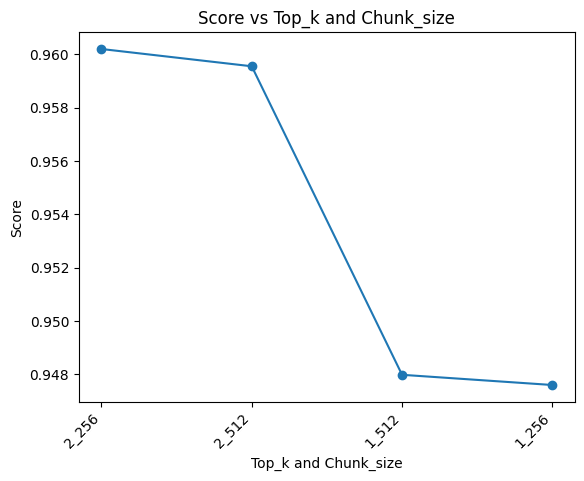

In [21]:
import matplotlib.pyplot as plt

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a line chart
plt.plot(top_k_chunk_combos, scores, marker='o', linestyle='-')
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()


Score: 0.9601992491856246, Top_k: 2, Chunk_size: 256
Score: 0.9595517151982862, Top_k: 2, Chunk_size: 512
Score: 0.9479836654918298, Top_k: 1, Chunk_size: 512
Score: 0.9476009379886216, Top_k: 1, Chunk_size: 256


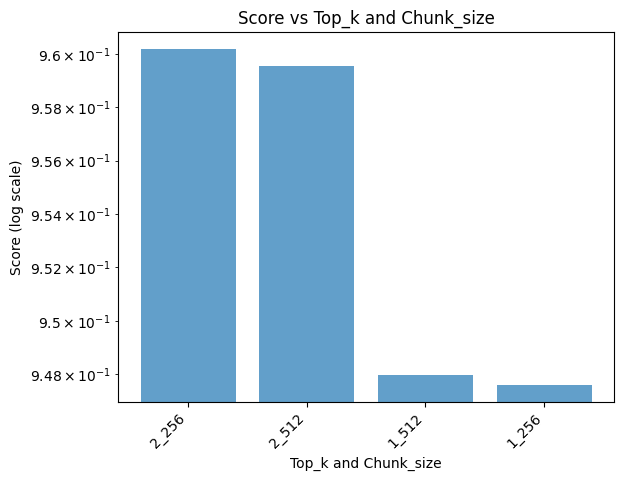

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# use the following lists to store data
scores = []
top_k_chunk_combos = []

for result in results.run_results:
    p = result.params
    score = result.score
    top_k = p["top_k"]
    chunk_size = p["chunk_size"]

    # Combine top_k and chunk_size for x-axis label
    top_k_chunk_combo = f"{top_k}_{chunk_size}"

    # Append values to the lists
    scores.append(score)
    top_k_chunk_combos.append(top_k_chunk_combo)

    print(f"Score: {score}, Top_k: {top_k}, Chunk_size: {chunk_size}")

# Create a bar chart with log scale for the y-axis
plt.bar(top_k_chunk_combos, scores, align='center', alpha=0.7)
plt.yscale('log')  # Set log scale for the y-axis
plt.xlabel('Top_k and Chunk_size')
plt.ylabel('Score (log scale)')
plt.title('Score vs Top_k and Chunk_size')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()
